In [1]:
import datetime as dt
import itertools
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from mcs_prime import McsTracks, McsTrack, PATHS

# %matplotlib inline

Load all tracks from 2000/6-2020/12

In [2]:
tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])

In [3]:
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [4]:
tracks.dstracks

<xarray.Dataset>
Dimensions:                  (tracks: 32843, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 32839 32840 32841 32842
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] 2019-01-01T00:30:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2019-01-02T12:30:00 ... ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon Feb 28 05:50:54 2022
    startdate:                   20190101.0000
    enddate:                     20200101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [5]:
natural = np.isnan(tracks.dstracks.start_split_cloudnumber.values)

In [6]:
tracks.dstracks.start_split_cloudnumber.values

array([nan, nan, nan, ..., nan, 60., 17.])

In [7]:
natural

array([ True,  True,  True, ...,  True, False, False])

In [8]:
natural.sum()

20955

In [9]:
dsnat = tracks.dstracks.sel(tracks=natural)

In [10]:
dsnat.track_duration.values

array([37, 28, 17, ...,  7,  6,  7], dtype=int32)

In [11]:
from itertools import product

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.600e+01, 2.640e+02,
        3.590e+02, 5.260e+02, 7.100e+02, 8.850e+02, 1.040e+03, 1.115e+03,
        1.117e+03, 1.157e+03, 1.136e+03, 1.130e+03, 9.800e+02, 9.460e+02,
        9.020e+02, 8.060e+02, 7.510e+02, 6.860e+02, 6.210e+02, 5.270e+02,
        5.180e+02, 4.430e+02, 3.980e+02, 3.900e+02, 3.050e+02, 2.730e+02,
        2.650e+02, 2.490e+02, 2.100e+02, 1.850e+02, 1.530e+02, 1.570e+02,
        1.370e+02, 1.330e+02, 1.180e+02, 1.100e+02, 1.180e+02, 9.500e+01,
        8.400e+01, 7.500e+01, 6.100e+01, 4.500e+01, 6.500e+01, 4.800e+01,
        4.800e+01, 3.900e+01, 3.500e+01, 4.000e+01, 3.100e+01, 2.800e+01,
        3.200e+01, 3.000e+01, 2.700e+01, 1.800e+01, 1.500e+01, 1.900e+01,
        1.400e+01, 1.000e+01, 1.000e+01, 1.100e+01, 8.000e+00, 8.000e+00,
        1.700e+01, 8.000e+00, 8.000e+00, 8.000e+00, 7.000e+00, 8.000e+00,
        4.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 1.000e+01, 1.000e+0

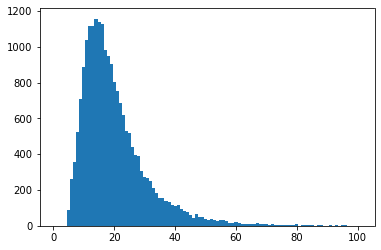

In [12]:
plt.hist(dsnat.track_duration.values, bins=np.linspace(0.5, 100.5, 101))

In [13]:
natural = np.isnan(tracks.dstracks.start_split_cloudnumber.values)
filter_vals = {'natural': {'natural': natural}}

print('  equator-tropics-extratropics')
mean_lat = np.nanmean(tracks.dstracks.meanlat.values, axis=1)
# Not having 5 values for lat bands makes the figure much clearer.
# filter_vals['equator-tropics-extratropics'] = {
#     'NH extratropics': mean_lat > 30,
#     'NH tropics': (mean_lat <= 30) & (mean_lat > 10), 
#     'equatorial': (mean_lat <= 10) & (mean_lat >= -10),
#     'SH tropics': (mean_lat < -10) & (mean_lat >= -30),
#     'SH extratropics': mean_lat < -30, 
# }
filter_vals['equator-tropics-extratropics'] = {
    'equatorial': (mean_lat <= 10) & (mean_lat >= -10),
    'tropics': ((mean_lat <= 30) & (mean_lat > 10)) | ((mean_lat < -10) & (mean_lat >= -30)), 
    'extratropics': (mean_lat > 30) | (mean_lat < -30),
}

print('  land-sea')
mean_landfrac = np.nanmean(tracks.dstracks.pf_landfrac.values, axis=1)
thresh_land = 0.5
thresh_sea = 0.5
filter_vals['land-sea'] = {
    'sea': mean_landfrac <= thresh_sea,
    'land': mean_landfrac > thresh_land,
}

# Build combinartorial product of filters.
filter_key_combinations = list(product(
    filter_vals['natural'].keys(),
    filter_vals['equator-tropics-extratropics'].keys(),
    filter_vals['land-sea'].keys(),
))


  equator-tropics-extratropics
  land-sea


In [14]:
filter_key_combinations

[('natural', 'equatorial', 'sea'),
 ('natural', 'equatorial', 'land'),
 ('natural', 'tropics', 'sea'),
 ('natural', 'tropics', 'land'),
 ('natural', 'extratropics', 'sea'),
 ('natural', 'extratropics', 'land')]

In [15]:
colours = dict(zip(
    filter_vals['equator-tropics-extratropics'].keys(),
    plt.rcParams['axes.prop_cycle'].by_key()['color']
))
# Linestyles determined by land-sea.
linestyles = dict(zip(
    filter_vals['land-sea'].keys(),
    ['-', '--']
))


In [16]:
grouped_data_dict = {}
# Apply filters.
for filter_keys in filter_key_combinations:
    full_filter = None
    for filter_name, key in zip(filter_vals.keys(), filter_keys):
        if full_filter is None:
            full_filter = filter_vals[filter_name][key]
        else:
            full_filter = full_filter & filter_vals[filter_name][key]

    plot_kwargs = {
        'color': colours[filter_keys[1]],
        'linestyle': linestyles[filter_keys[2]],
    }
    percentage = full_filter.sum() / natural.sum() * 100
    label = ' '.join(filter_keys[1:]) + f' ({percentage:.1f}%)'
    grouped_data_dict[label] = {
        'ds': tracks.dstracks.isel(tracks=full_filter),
        'label': label,
        'plot_kwargs': plot_kwargs,
    }



In [17]:
natural.sum()

20955

In [18]:
grouped_data_dict

{'equatorial sea (27.2%)': {'ds': <xarray.Dataset>
  Dimensions:                  (tracks: 5705, times: 400, mergers: 50, nmaxpf: 3)
  Coordinates:
    * tracks                   (tracks) int64 3 5 6 9 ... 32817 32820 32822 32828
    * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
    * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    * nmaxpf                   (nmaxpf) int64 0 1 2
  Data variables: (12/55)
      track_duration           (tracks) int32 40 16 115 11 12 ... 16 14 13 13 10
      start_status             (tracks) float64 15.0 15.0 15.0 ... 1.0 1.0 1.0
      end_status               (tracks) float64 3.0 34.0 0.0 37.0 ... 3.0 3.0 0.0
      start_basetime           (tracks) datetime64[ns] 2019-01-01T00:30:00 ... ...
      end_basetime             (tracks) datetime64[ns] 2019-01-02T15:30:00 ... ...
      start_split_cloudnumber  (tracks) float64 nan nan nan nan ... nan nan nan
      ...                       ...
    

equatorial sea (27.2%) - mean 22.3h gt40h: 7.3%
equatorial land (19.3%) - mean 18.6h gt40h: 2.4%
tropics sea (17.7%) - mean 21.2h gt40h: 5.9%
tropics land (13.7%) - mean 17.0h gt40h: 1.9%
extratropics sea (14.4%) - mean 21.7h gt40h: 10.2%
extratropics land (7.6%) - mean 17.7h gt40h: 4.4%


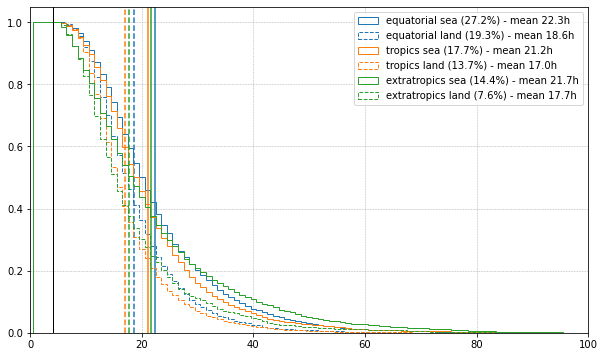

In [38]:
plt.figure(figsize=(10, 6))
for k, v in grouped_data_dict.items():
    c, ls = v['plot_kwargs']['color'], v['plot_kwargs']['linestyle']
    mean_duration = v['ds'].track_duration.values.mean()
    label = k + f' - mean {mean_duration:.1f}h'
    plt.hist(v['ds'].track_duration.values, bins=np.linspace(0.5, 100.5, 101), density=True, cumulative=-1, histtype='step', label=label, color=c, linestyle=ls)
    plt.axvline(x=mean_duration, color=c, ls=ls)
    duration_gt40_frac = (v['ds'].track_duration.values > 40).sum() / len(v['ds'].track_duration.values)
    print(label, f'gt40h: {duration_gt40_frac * 100:.1f}%')
    
plt.legend()
plt.xlim((0, 100))
plt.axvline(x=4, ls='-', lw=1, color='k')
plt.grid(ls='--', lw=0.5)

(array([   0.,    0.,    0.,    0.,  648., 1241., 1110., 1056.,  967.,
         879.,  912.,  791.,  725.,  644.,  686.,  552.,  533.,  482.,
         411.,  440.,  387.,  344.,  334.,  252.,  262.,  246.,  220.,
         202.,  201.,  189.,  190.,  162.,  169.,  150.,  146.,  135.,
         129.,  111.,  111.,   94.,  104.,   87.,   87.,   71.,   80.,
          74.,   60.,   61.,   65.,   77.]),
 array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,
         1600.,  1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,
         3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,
         4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,  6200.,
         6400.,  6600.,  6800.,  7000.,  7200.,  7400.,  7600.,  7800.,
         8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,
         9600.,  9800., 10000.]),
 <BarContainer object of 50 artists>)

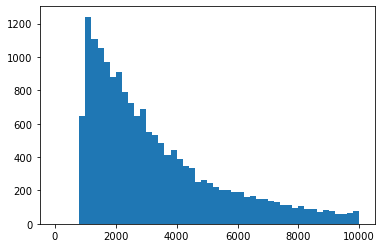

In [20]:
plt.hist(dsnat.ccs_area.values[:, 0], bins=np.linspace(0, 1e4, 51))

In [21]:
dsnat.ccs_area

<xarray.DataArray 'ccs_area' (tracks: 20955, times: 400)>
array([[1299400., 1027000.,  892300., ...,      nan,      nan,      nan],
       [1050300.,  846400., 1018800., ...,      nan,      nan,      nan],
       [ 972400.,  356700.,  351400., ...,      nan,      nan,      nan],
       ...,
       [   5600.,   25700.,   71800., ...,      nan,      nan,      nan],
       [   3200.,   14000.,   43700., ...,      nan,      nan,      nan],
       [   3200.,    8000.,   34900., ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32834 32835 32836 32838 32839 32840
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
Attributes:
    long_name:  Area of cold cloud shield
    units:      km^2

In [22]:
dsnat.mcs_status.values[-1][:7]

array([0., 0., 0., 1., 1., 1., 1.], dtype=float32)

In [23]:
np.percentile(dsnat.ccs_area.values[:, 0], [1, 10, 25, 50, 75, 90, 99])

array([   900.,   1200.,   1800.,   3300.,   7200.,  25700., 223122.])

In [24]:
(dsnat.ccs_area.values[:, 0] > 4e4).sum() / natural.sum() * 100

6.933905989024098